Для запуска необходимо иметь 5 файлов в папке с блокнотом
1. cpfX.py
2. read_bases.py
3. hapi.py
4. VIRAPROFILE.txt
5. Файл с линиями поглощения

## 0. Imports

In [1]:
# %matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import scipy
import os
from read_bases import *
from scipy import constants
import pandas as pd
from cpfX import hum1zpf16m #for Humlıcek approximation
from tqdm import tqdm #for loop time
from hapi import partitionSum

HAPI version: 1.2.2.2
To get the most up-to-date version please check http://hitran.org/hapi
ATTENTION: Python versions of partition sums from TIPS-2021 are now available in HAPI code

           MIT license: Copyright 2021 HITRAN team, see more at http://hitran.org. 

           If you use HAPI in your research or software development,
           please cite it using the following reference:
           R.V. Kochanov, I.E. Gordon, L.S. Rothman, P. Wcislo, C. Hill, J.S. Wilzewski,
           HITRAN Application Programming Interface (HAPI): A comprehensive approach
           to working with spectroscopic data, J. Quant. Spectrosc. Radiat. Transfer 177, 15-30 (2016)
           DOI: 10.1016/j.jqsrt.2016.03.005

           ATTENTION: This is the core version of the HITRAN Application Programming Interface.
                      For more efficient implementation of the absorption coefficient routine, 
                      as well as for new profiles, parameters and other functional,
      

## 1. Inputs

In [2]:
DATABASE = 'ames' # 'hitran' # 'ames', 'bezard'
FILENAME = 'Ames-2016.natural.co2.296k.list.long.format.dat' # '65f81198.par' # 'Ames-2016.natural.co2.296k.list.long.format.dat', bezard_hotco2_1mu_cdsd.dat'
PROFILE_FILENAME = 'VIRAPROFILE.txt'
AEROSOL_FILENAME = 'venusclouds_75_Haus16.txt'
LINES_PATH = 'lines data/'
INPUT_PATH = 'input/'

## 2. Compile DISORT

In [2]:
# must be lower than 1.26.x
np.version.version

'1.25.0'

In [3]:
!gcc --version
!gfortran --version

# must be 3.11.9 or lower
!python --version

gcc (MinGW-W64 x86_64-ucrt-posix-seh, built by Brecht Sanders, r3) 14.1.0
Copyright (C) 2024 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

GNU Fortran (MinGW-W64 x86_64-ucrt-posix-seh, built by Brecht Sanders, r3) 14.1.0
Copyright (C) 2024 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

Python 3.11.9


In [10]:
# !f2py -c src/BDREF.f src/DISORT.f src/ERRPACK.f src/LINPAK.f src/RDI1MACH.f src/GETMOM.f src/PRTFIN.f src/DRIVER.f -m disort --quiet

WARN: Could not locate executable g77
WARN: Could not locate executable f77
WARN: Could not locate executable ifort
WARN: Could not locate executable ifl
WARN: Could not locate executable f90
WARN: Could not locate executable DF
WARN: Could not locate executable efl


rmbadname1: Replacing "float" with "float_bn".
rmbadname1: Replacing "len" with "len_bn".
rmbadname1: Replacing "max" with "max_bn".
rmbadname1: Replacing "min" with "min_bn".
rmbadname1: Replacing "max" with "max_bn".
rmbadname1: Replacing "min" with "min_bn".
rmbadname1: Replacing "min" with "min_bn".
rmbadname1: Replacing "float" with "float_bn".
rmbadname1: Replacing "max" with "max_bn".
rmbadname1: Replacing "min" with "min_bn".
rmbadname1: Replacing "max" with "max_bn".
rmbadname1: Replacing "min" with "min_bn".
rmbadname1: Replacing "min" with "min_bn".
rmbadname1: Replacing "max" with "max_bn".
rmbadname1: Replacing "min" with "min_bn".
rmbadname1: Replacing "float" with "float_bn".
rmbadname1: Replacing "index" with "index_bn".
C:\Users\underhamster\miniconda3\envs\py311\Lib\site-packages\setuptools\_distutils\cmd.py:66: SetuptoolsDeprecationWarning: setup.py install is deprecated.
!!

        ********************************************************************************
   

In [9]:
# !del *.dll

In [11]:
# !move disort\.libs\*.dll 

C:\Users\underhamster\IKI\sigma_disort2\disort\.libs\libBDREF.UUTIEUCV3XBHOP6D7UZPYLGJRD5GGQL2.gfortran-win_amd64.dll
        1 Datei(en) verschoben.


## 3. Load data

### 3.1 spectral lines

#### read whole file

In [8]:
if DATABASE == 'hitran':
    spectral_line_data = read_hitran2012(LINES_PATH + FILENAME)
elif DATABASE == 'ames':
    spectral_line_data = read_ames(LINES_PATH + FILENAME)
elif DATABASE == 'bezard':
    spectral_line_data = read_bezard(LINES_PATH + FILENAME)
    

Reading "lines data/Ames-2016.natural.co2.296k.list.long.format.dat" ...


In [9]:
# df = pd.DataFrame(spectral_line_data)

In [10]:
# df

In [11]:
# plt.scatter(df.linecenter, df.S, s=0.5)
# plt.show();

#### limit to required range

In [12]:
spectral_line_data['linecenter']

array([1.88710000e-01, 2.09674000e-01, 2.31741000e-01, ...,
       2.39860656e+04, 2.39873404e+04, 2.39885275e+04])

In [13]:
left_limit = 9400 # cm^-1
right_limit = 11000
span = right_limit - left_limit

In [14]:
required_slice = np.where((spectral_line_data['linecenter'] >= left_limit) & (spectral_line_data['linecenter'] <= right_limit))[0]
required_slice

array([1044063, 1044064, 1044065, ..., 1107728, 1107729, 1107730],
      dtype=int64)

In [15]:
# index_start = 1032907  # 1044063
# index_end = 1118650    # 1107731


index_start = max((int(required_slice[0] - 250 * len(required_slice) / span), 0))
index_end = min((int(required_slice[-1] + 250 * len(required_slice) / span), len(spectral_line_data['linecenter'])-1))

m = index_end - index_start
m

83564

In [16]:
index_start

1034114

In [17]:
index_end

1117678

In [18]:
mask = slice(index_start, index_end)

E = spectral_line_data['Epp'][mask]
sw = spectral_line_data['S'][mask]
iso = spectral_line_data['I'][mask]

pshift = spectral_line_data['delta'][mask]
n = spectral_line_data['N'][mask]

gamma_self = np.array(spectral_line_data['gamma-self'])[mask]
gamma_air = 1.5 * spectral_line_data['gamma-air'][mask]


In [19]:
gamma_self

array([0.1032, 0.0689, 0.1072, ..., 0.08  , 0.08  , 0.0827])

In [20]:
pshift

array([-0.009935, -0.012319, -0.009131, ..., -0.01419 , -0.01419 ,
       -0.013247])

### 3.2 pressure, height, density, temperature profile of the atmoshpere with altitude

In [21]:
pressure, height, density, temperature = np.loadtxt(INPUT_PATH + PROFILE_FILENAME, skiprows = 1, unpack=True)

### 3.3 molar mass

In [22]:
np.unique(iso)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=int64)

In [23]:
molar_mass_reference = np.array([43.989830, 44.993185, 45.994076, 44.994045,
                                 46.997431, 45.997400, 47.998320, 46.998291,
                                 45.998262, 49.001675, 48.001646, 47.001618])

mol_mass = []
for j in range(m):
    mol_mass.append(molar_mass_reference[iso[j]-1])

## 4. Doppler and Lorentz full width at half maximum

In [24]:
Na = scipy.constants.N_A # mol^-1
ka  = 1.380649e-16 # erg K^−1
c = 2.99792458e10 # cms^−1
c2 = 1.4387769 # cm K

def doppler_fwhm(w0,T, Molm):

    return w0/c*np.sqrt(2*Na*ka*T/Molm)

def lorenz_fwhm(w0, p, T, gamma_self, gamma_air, p_self, pshift, n):

    return ((296/T)**n)*(gamma_self*p_self + gamma_air*(p-p_self))

## 5. Calculating cross-sections

In [25]:
w = np.arange(9150, 11250.01, 0.5) #wavenumber range for calculating profiles 9400-1000.01 cm^-1 with cut-off ±250 cm^-1

In [26]:
# N = 101

In [27]:
# spectrum = []
# profiles_ = []
# #Loop for viraprofile of temperature and pressure
# for l in tqdm(np.arange(0,N)):
#     nu = np.array(spectral_line_data['linecenter'])[mask]
#     p_self = pressure[l]
#     T = temperature[l]
#     p = pressure[l]


#     wD = doppler_fwhm(nu,T, mol_mass) #calculating half-width at half-maximum for doppler
#     wL = lorenz_fwhm(nu, p, T, gamma_self, gamma_air, p_self, pshift, n) #for Lorentz

#     #Calculating the spectrum of cross-sections
#     sigma = np.zeros(w.size)
#     for k in np.arange(0,m):
#         #Calculating line strength
#         Q = partitionSum(2,iso[k],296) #uses hapi module to calculate partition sums
#         Qt = partitionSum(2,iso[k],T)
#         intensities = sw[k]*Q/Qt*(np.exp(-c2*E[k]/T)/np.exp(-c2*E[k]/296))*(1 - np.exp(-c2*nu[k]/T))/(1 - np.exp(-c2*nu[k]/296))
#         ## ======================================================

#         nu[k] = nu[k] + pshift[k] *p

#         #chi facotor
#         delta_nu = np.absolute(w - nu[k])

#         mask1 = delta_nu < 3
#         mask2 = (delta_nu > 3)&(delta_nu<20)
#         mask3 = (delta_nu > 20)&(delta_nu<120)
#         mask4 = (delta_nu>120)&(delta_nu<250)
#         mask5 = delta_nu>250 #line cut-off

#         chi1 = np.ones(delta_nu[mask1].shape)

#         chi2 = 1.22*np.exp(-delta_nu[mask2]/15)

#         chi3 = 0.3477*np.exp(-delta_nu[mask3]/260)

#         chi4 = 0.7276*np.exp(-delta_nu[mask4]/100)

#         chi5 = 0

#         #Calculating voight profiles with Humlıcek approximation

#         y = wL[k] / wD[k]
#         x = (w-nu[k]) / wD[k]

#         scale = 1/(wD[k]*np.sqrt(np.pi))

#         profile = hum1zpf16m(x, y)*scale


#         profile[mask1] = profile[mask1]*chi1
#         profile[mask2] = profile[mask2]*chi2
#         profile[mask3] = profile[mask3]*chi3
#         profile[mask4] = profile[mask4]*chi4
#         profile[mask5] = profile[mask5]*chi5


#         # calculating cross_sections

#         cross_section = profile*intensities
#         cross_section = cross_section.real

#         # calculating spectrum
#         sigma += cross_section

#     print(nu)
#     print(sigma)
#     spectrum.append(sigma)

In [28]:
# H = 99
# plt.close();
# plt.plot(w, spectrum[H], linewidth=0.5)
# plt.title(f'absorbtion at height of {int(height[H])} km')
# plt.xlabel('wavenumber, $cm^{-1}$')
# plt.ylabel('sigma, $cm^2$')
# plt.show();

## 6. Calculating extinction

In [29]:
# ex = density*1e5
# ex_profiles = []
# for z in tqdm(np.arange(0,N)):
#     ep = spectrum[z]*ex[z]
#     ex_profiles.append(ep)

In [30]:
# ex_profiles = np.asarray(ex_profiles)
# ex_profiles[:,2500:18501].shape

## 7. Exporting to binary file

In [31]:
w_range_start = np.argmin(np.abs(w - left_limit))
w_range_end = np.argmin(np.abs(w - right_limit))

In [32]:
# ex_profiles = np.asarray(ex_profiles)
# ex_profiles_final = ex_profiles[:,w_range_start:w_range_end]  #selecting the right range of values
# rev = ex_profiles_final[::-1]
# rev.shape

In [33]:
w_cut = w[w_range_start:w_range_end]

In [34]:
len(w)

4201

In [35]:
len(w_cut)

3200

In [36]:
# rev

In [37]:
# plt.close();
# plt.plot(height, np.mean(spectrum, axis=1) , linewidth=0.5)
# plt.xlabel('height, km')
# plt.ylabel('max sigma, $cm^2$')
# plt.show();

In [38]:
# plt.close();
# plt.plot(w_cut, rev[50], linewidth=0.5)
# plt.show();

In [39]:
# rev

In [40]:
# rev.tofile('input_disort_venus_ames', format = '%02.0f') #exporting to binary file

In [41]:
# res = np.fromfile('input_disort_venus_ames')

In [42]:
# res.shape

In [43]:
# np.save('output/sigmas_CO2_ames', rev)

In [237]:
gas_abs = np.load('output/sigmas_CO2_ames.npy') # * 10**2

In [238]:
gas_abs

array([[7.93790496e-11, 4.70248768e-11, 6.95152629e-11, ...,
        1.23644607e-09, 9.67963776e-13, 5.68141958e-12],
       [1.35254619e-10, 7.93042274e-11, 1.15717514e-10, ...,
        1.52236817e-09, 1.64010234e-12, 9.60617217e-12],
       [2.30439929e-10, 1.34078957e-10, 1.93981816e-10, ...,
        1.87218087e-09, 2.77848368e-12, 1.62382984e-11],
       ...,
       [8.42818932e-01, 8.70240099e-01, 8.98712337e-01, ...,
        1.11988381e-02, 1.17797925e-02, 1.23471506e-02],
       [8.83492868e-01, 9.11173325e-01, 9.39908066e-01, ...,
        1.15403566e-02, 1.21165590e-02, 1.26739496e-02],
       [9.25138708e-01, 9.52967565e-01, 9.81897961e-01, ...,
        1.18759671e-02, 1.24424845e-02, 1.29893859e-02]])

## 8. Compute aerosol scattering & absorption

In [239]:
from scipy.interpolate import interp1d, interp2d
import scipy.io

In [240]:
# Интерполяция данных атмосферы

atm = np.column_stack([
    pressure, 
    height, 
    density, 
    temperature
])

# Коррекция верхней границы облаков
dhrange = np.arange(0, -12, -2)  # создаем массив от 0 до -10 с шагом -2
dh = dhrange[0]  # выбираем первое значение из массива

In [241]:
# Переменные: ic, sf, hmin, iw, SFCEMIS
sf = 1 # 2.4  # коэффициент масштабирования облачных аэрозолей
ic = 0.0  # коэффициент континуума CO2
ihdo = 1  # HDO = 1 => H2O/HDO = 128 SMOW; HDO = 0 => без HDO
iw = 16    # объёмное соотношение смешивания H2O (VMR = Nh2o/Nco2)
SFCEMIS = 0.95  # эмиссионная способность поверхности

# for sf in np.arange(2.4, 0.3, -0.4):  # цикл для sf (2.4, 2.0, 1.6, 1.2, 0.8, 0.4)
# for ic in [0.0]:  # цикл для ic
# ihdo = 1  # цикл для ihdo (можно оставить как есть, если не нужно менять)
# for hmin in range(-2, 11):  # цикл для hmin (-2 до 10)
# for iw in range(16, 41, 4):  # цикл для iw (16, 20, 24, 28, 32, 36, 40)
# for SFCEMIS in [0.95]:  # цикл для SFCEMIS

In [242]:
# Оптические свойства аэрозолей
data = np.loadtxt(INPUT_PATH + AEROSOL_FILENAME)

# Расчет рассеяния и поглощения аэрозолей
modeH = [1, 21, 22, 3]
wavenum = data[::4, 0]
wavelen = data[::4, 1]

modes = data[:, 2].reshape(4, len(wavenum))
Cext = data[:, 3].reshape(4, len(wavenum)).T
Galb = data[:, 4].reshape(4, len(wavenum)).T
Gass = data[:, 5].reshape(4, len(wavenum)).T
Csca = data[:, 6].reshape(4, len(wavenum)).T

nphi = 51
nL = 101
MILC = data[:, 7 + nphi * 2:].reshape(4, len(wavenum), nL)
mileg = np.zeros((len(wavenum), nL, 4))

for i in range(4):
    mileg[:, :, i] = MILC[i, :, :]

zb = np.array([49, 65, 49, 49])
zb[:2] += dh
zc = np.array([16, 1, 11, 8])
N0 = np.array([193.5, 100, 50, 14])
N0[1:] *= sf
Hup = np.array([3.5, 3.5, 1.0, 1.0])
Hlo = np.array([1.0, 3.0, 0.1, 0.5])

N = np.zeros((len(atm[:, 1]), 4))

for i in range(4):
    idx1 = atm[:, 1] > (zb[i] + zc[i])
    idx2 = (atm[:, 1] <= (zb[i] + zc[i])) & (atm[:, 1] >= zb[i])
    idx3 = atm[:, 1] < zb[i]
    
    N[idx1, i] = N0[i] * np.exp(-(atm[idx1, 1] - (zb[i] + zc[i])) / Hup[i])
    N[idx2, i] = N0[i]
    N[idx3, i] = N0[i] * np.exp(-(zb[i] - atm[idx3, 1]) / Hlo[i])

aer_ext = np.dot(Cext, N.T) / 1000  # Cext [micron^2] * N [1/cm^3] * 10^(-3) --> km^(-1)
aer_sca = np.dot(Csca, N.T) / 1000

aer_ext = aer_ext.T
aer_sca = aer_sca.T

gfmat = Gass

scamat = np.zeros((len(wavelen), len(atm[:, 1]), 4))
for i in range(4):
    scamat[:, :, i] = np.dot(Csca[:, i].reshape(-1, 1), N[:, i].reshape(1, -1)) / 1000

aer_ssalb = aer_sca / aer_ext
aer_ssalb[aer_ext <= 0] = 0

In [243]:
N.shape

(101, 4)

In [244]:
Csca.shape

(70, 4)

In [245]:
aer_ext.shape

(101, 70)

In [296]:
# Инициализация массива для рассеяния Рэлея
rayleigh = np.zeros((len(atm[:, 2]), len(w_cut)))

# Вычисление длины волны
lambda_vals = 1e4 / w_cut

In [297]:
# Цикл для вычисления рассеяния Рэлея для каждого значения в атмосфере
for i in range(len(atm[:, 1])):
    mus = (6.99100e-2 / (166.175000 - lambda_vals**(-2)) +
           1.44720e-3 / (79.609000 - lambda_vals**(-2)) +
           6.42941e-5 / (56.306400 - lambda_vals**(-2)) +
           5.21306e-5 / (46.019600 - lambda_vals**(-2)) +
           1.46847e-6 / (0.0584738 - lambda_vals**(-2)))
    
    n = 1 + mus * atm[i, 0] / atm[i, 3] * 273.15 / 1.01325
    
    rayleigh[i, :] = (24 * np.pi**3 / (lambda_vals * 1e-4)**4 / atm[i, 2]**2 *
                      ((n**2 - 1) / (n**2 + 2))**2 *
                      (1.14 + 25.3e-12 / lambda_vals**2) * atm[i, 2])

# Преобразование единиц
rayleigh *= 1e5

In [248]:
atm[:, 1]

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100.])

In [249]:
rayleigh.shape

(3200, 101)

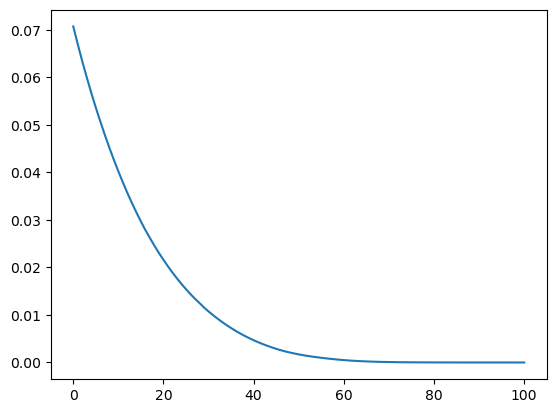

In [250]:
plt.plot(atm[:, 1], rayleigh_interp[:, 0])

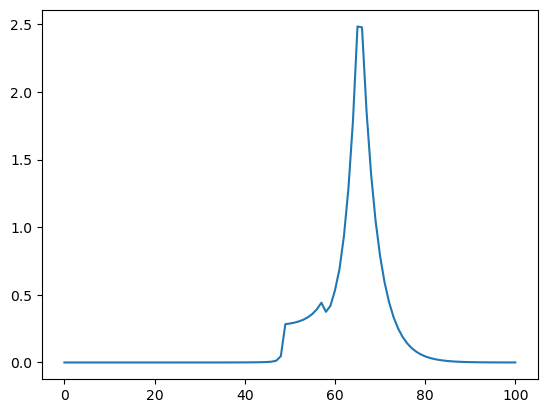

In [251]:
plt.plot(atm[:, 1], aer_ext[:, 0])

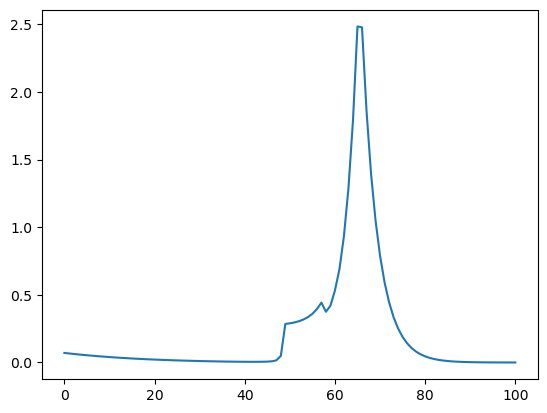

In [252]:
plt.plot(atm[:, 1], aer_ext[:, 0] + rayleigh_interp[:, 0])

In [253]:
gas_abs.shape

(101, 3200)

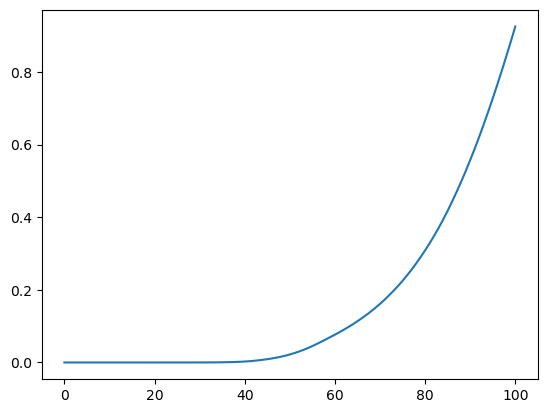

In [254]:
plt.plot(atm[:, 1], gas_abs[:, 0])

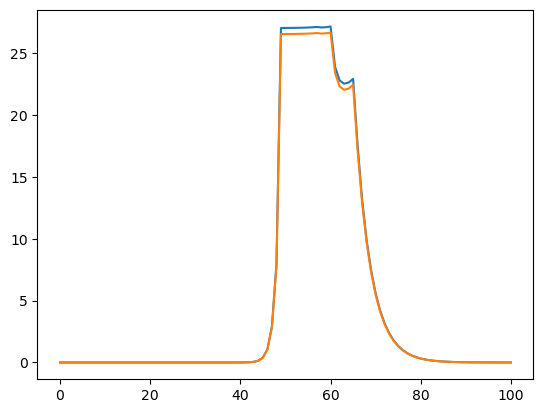

In [255]:
plt.plot(atm[:, 1], aer_ext[:, 55])
plt.plot(atm[:, 1], aer_sca[:, 55])

In [256]:
aer_ext.shape

(101, 70)

In [257]:
wavenum

array([ 4000.,  4100.,  4200.,  4300.,  4400.,  4500.,  4600.,  4700.,
        4800.,  4900.,  5000.,  5100.,  5200.,  5300.,  5400.,  5500.,
        5600.,  5700.,  5800.,  5900.,  6000.,  6100.,  6200.,  6300.,
        6400.,  6500.,  6600.,  6700.,  6800.,  6900.,  7000.,  7100.,
        7200.,  7300.,  7400.,  7500.,  7600.,  7700.,  7800.,  7900.,
        8000.,  8200.,  8400.,  8600.,  8800.,  9000.,  9200.,  9400.,
        9600.,  9800., 10000., 10200., 10400., 10600., 10800., 11000.,
       11200., 11400., 11600., 11800., 12000., 12200., 12400., 12600.,
       12800., 13000., 13200., 13400., 13600., 13800.])

In [258]:
w_cut

array([ 9400. ,  9400.5,  9401. , ..., 10998.5, 10999. , 10999.5])

In [259]:
aer_ext_interp = interp1d(wavenum, aer_ext, axis=1, kind='linear', fill_value='extrapolate')(w_cut)

In [260]:
aer_ext_interp.shape

(101, 3200)

In [300]:
# Параметры RTM
from scipy.interpolate import RegularGridInterpolator

emis_ang = 0
SFCTEMP = atm[0, 3]

ZZ = atm[::-1, 1]
TT = atm[::-1, 3]
delta_zz = np.abs(np.diff(ZZ))

GF = np.zeros_like(gas_abs)  # текущий геометрический фактор уровня

LEGW = np.zeros((len(w_cut), len(ZZ), 5))  # Весовые коэффициенты Лежандра
MLEG = np.zeros((nL, len(w_cut), 5))  # Коэффициенты Лежандра MI

MLEG[0, :, :] = 1
MLEG[2, :, 4] = 0.1
for iL in range(1, nL):
    for im in range(4):
        MLEG[iL, :, im] = interp1d(wavenum, mileg[:, iL, im], kind='linear', fill_value='extrapolate')(w_cut)


aer_ext_interp = interp1d(wavenum, aer_ext, axis=1, kind='linear', fill_value='extrapolate')(w_cut)
aer_sca_interp = interp1d(wavenum, aer_sca, axis=1, kind='linear', fill_value='extrapolate')(w_cut)

TAUCL = gas_abs + aer_ext_interp + rayleigh  # текущий уровень экстинкции
SCACL = aer_sca_interp + rayleigh        # текущий уровень рассеяния
TAUCL = TAUCL[::-1, :]                # однократное рассеяние (однородное поглощение)
SCACL = SCACL[::-1, :]
SSALB = SCACL / TAUCL

for i in range(len(ZZ)-1, -1, -1):
    i1 = len(ZZ) - i - 1

    GF[i1,:] = (interp1d(wavenum, gfmat[:, 0] * scamat[:, i, 0], kind='linear', fill_value='extrapolate')(w_cut) +
                 interp1d(wavenum, gfmat[:, 1] * scamat[:, i, 1], kind='linear', fill_value='extrapolate')(w_cut) +
                 interp1d(wavenum, gfmat[:, 2] * scamat[:, i, 2], kind='linear', fill_value='extrapolate')(w_cut) +
                 interp1d(wavenum, gfmat[:, 3] * scamat[:, i, 3], kind='linear', fill_value='extrapolate')(w_cut))  / SCACL[i1,:]
    for im in range(4):
        LEGW[:, i1, im] = interp1d(wavenum, scamat[:, i, im], kind='linear', fill_value='extrapolate')(w_cut)
    LEGW[:, i1, 4] = rayleigh[i, :]

TAUSUM = (TAUCL[:-1, :] + TAUCL[1:, :]) / 2 * np.repeat(delta_zz[np.newaxis, :], len(w_cut), axis=0).T
SCASUM = (SCACL[:-1, :] + SCACL[1:, :]) / 2 * np.repeat(delta_zz[np.newaxis, :], len(w_cut), axis=0).T
LEGW = (LEGW[:, :-1, :] + LEGW[:, 1:, :]) / 2 * np.repeat(delta_zz[np.newaxis, :, np.newaxis], len(w_cut), axis=0)
for im in range(5):
    LEGW[:, :, im] = LEGW[:, :, im] / SCASUM.T
SSALB = (SSALB[:-1, :] + SSALB[1:, :]) / 2
GF = (GF[:-1, :] + GF[1:, :]) / 2

imin = 0
imax = len(w_cut)
lmax = 40
NLG0 = lmax

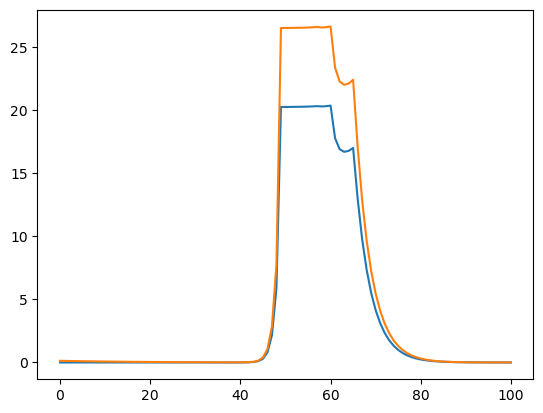

In [301]:
test = np.zeros_like(gas_abs)

for i in range(len(ZZ)-1, -1, -1):
    i1 = len(ZZ) - i - 1

    test[i1,:] = (interp1d(wavenum, gfmat[:, 0] * scamat[:, i, 0], kind='linear', fill_value='extrapolate')(w_cut) +
                 interp1d(wavenum, gfmat[:, 1] * scamat[:, i, 1], kind='linear', fill_value='extrapolate')(w_cut) +
                 interp1d(wavenum, gfmat[:, 2] * scamat[:, i, 2], kind='linear', fill_value='extrapolate')(w_cut) +
                 interp1d(wavenum, gfmat[:, 3] * scamat[:, i, 3], kind='linear', fill_value='extrapolate')(w_cut))

plt.plot(ZZ, test[:, -1])
plt.plot(ZZ, SCACL[:, -1])

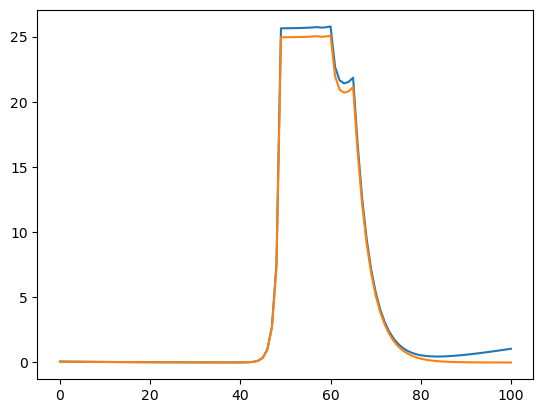

In [302]:
moo=20
plt.plot(atm[:, 1], aer_ext_interp[:, moo] + rayleigh_interp[:, moo] + gas_abs[:, moo])
plt.plot(atm[:, 1], aer_sca_interp[:, moo] + rayleigh_interp[:, moo])

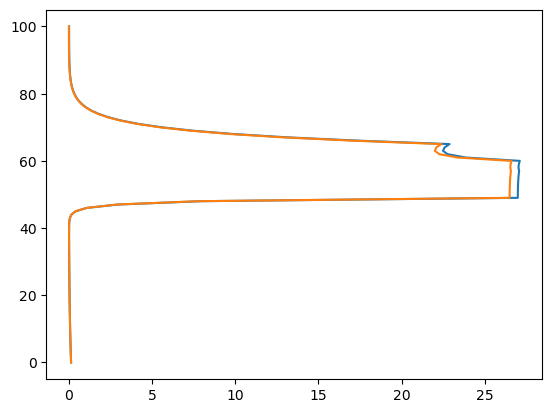

In [264]:
plt.plot(TAUCL[:, -1], ZZ)
plt.plot(SCACL[:, -1], ZZ)

In [265]:
ZZ

array([100.,  99.,  98.,  97.,  96.,  95.,  94.,  93.,  92.,  91.,  90.,
        89.,  88.,  87.,  86.,  85.,  84.,  83.,  82.,  81.,  80.,  79.,
        78.,  77.,  76.,  75.,  74.,  73.,  72.,  71.,  70.,  69.,  68.,
        67.,  66.,  65.,  64.,  63.,  62.,  61.,  60.,  59.,  58.,  57.,
        56.,  55.,  54.,  53.,  52.,  51.,  50.,  49.,  48.,  47.,  46.,
        45.,  44.,  43.,  42.,  41.,  40.,  39.,  38.,  37.,  36.,  35.,
        34.,  33.,  32.,  31.,  30.,  29.,  28.,  27.,  26.,  25.,  24.,
        23.,  22.,  21.,  20.,  19.,  18.,  17.,  16.,  15.,  14.,  13.,
        12.,  11.,  10.,   9.,   8.,   7.,   6.,   5.,   4.,   3.,   2.,
         1.,   0.])

In [266]:
np.arange(0, 100, 1)[::-1]

array([99, 98, 97, 96, 95, 94, 93, 92, 91, 90, 89, 88, 87, 86, 85, 84, 83,
       82, 81, 80, 79, 78, 77, 76, 75, 74, 73, 72, 71, 70, 69, 68, 67, 66,
       65, 64, 63, 62, 61, 60, 59, 58, 57, 56, 55, 54, 53, 52, 51, 50, 49,
       48, 47, 46, 45, 44, 43, 42, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32,
       31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15,
       14, 13, 12, 11, 10,  9,  8,  7,  6,  5,  4,  3,  2,  1,  0])

In [267]:
min(SSALB), max(SSALB)

(0.00015138508180549402, 0.9999999999997804)

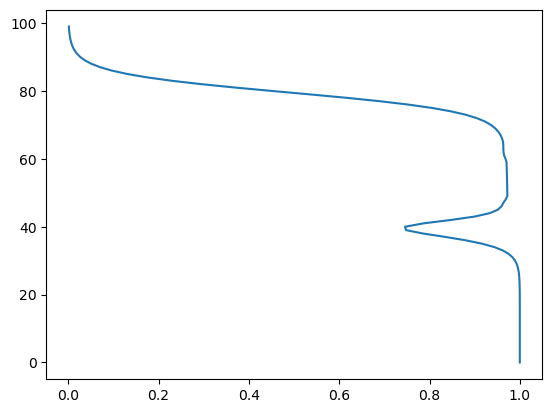

In [268]:
plt.plot(SSALB[:, 0], np.arange(0, 100, 1)[::-1])

In [269]:
min(GF), max(GF)

(1.598290319800026e-10, 0.8036995749971667)

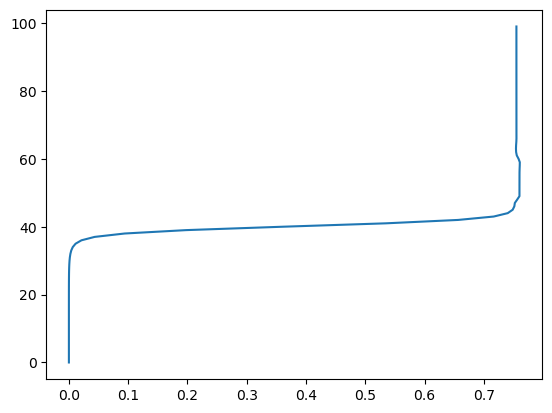

In [270]:
plt.plot(GF[:, 50], np.arange(0, 100, 1)[::-1])

In [271]:
GF.shape

(100, 3200)

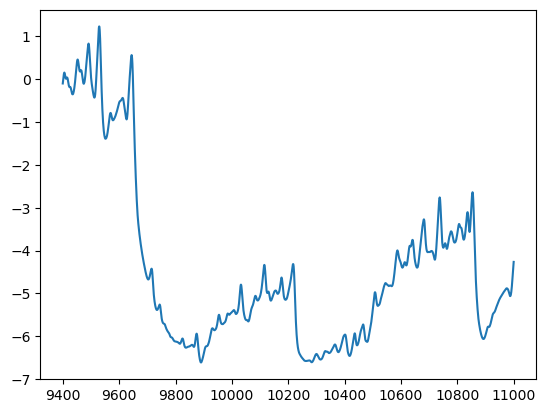

In [272]:
plt.plot(w_cut, np.log(TAUSUM[0, :]))

In [273]:
min(gfmat), max(gfmat)

(0.55655122, 0.81959628)

In [274]:
min(scamat), max(scamat)

(5.057644416571644e-215, 21.341415122369998)

In [12]:
import disort

In [276]:
NLYR = len(ZZ)-1

UMU = [-1.0, -0.9848, -0.9397, -0.8660, -0.7660, -0.6428, -0.5, 
       -0.3420, -0.1736, -0.0872, -.01, .01,  0.0872, 0.1736,
       0.3420,  0.5,  0.6428,  0.7660,  0.8660,  0.9397,  0.9848, 1.0]



# UMU = np.array([-1.,-0.5,0.5,1.])

PHI0 = 0
PHI = [0]

UMU0 = 1
FISOT = 0.0

IBCND = 0
FBEAM = 0

LAMBER = True
ALBEDO = 1. - SFCEMIS
PLANK = True
TTEMP = 0.
TEMIS = 1.0

ONLYFL = False
USRTAU = False
USRANG = True
# PRNT = np.array([False, False, False, False, True])
PRNT = np.array([True, True, True, True, True])

NSTR = 32
MAXMOM = 299
MAXCLY = NLYR
MAXUMU = len(UMU)
MAXPHI = len(PHI)
MAXULV = NLYR + 1

ACCUR = 1e-6

IPHAS = [3]*NLYR
# GG =  np.ones(NLYR)*0.85
UTAU = np.zeros(NLYR+1)

# WVNMLO = 9400
# WVNMHI = 11000

In [277]:
MAXUMU

22

In [278]:
uu_ = []
# GF[:,i]

In [280]:
for i, w in enumerate(w_cut):
    [rfldir, rfldn, flup, dfdt, uavg, uu, albmed, trnmed] =\
                                disort.run(dtauc=TAUSUM[:,i], ssalb=SSALB[:,i], iphas=IPHAS, gg=GF[:,i],
                                            umu0=UMU0, phi0=PHI0, albedo=ALBEDO, fbeam=FBEAM,
                                            usrtau=USRTAU, utau=UTAU, usrang=USRANG, umu=UMU,
                                            phi=PHI, nstr=NSTR, maxmom=MAXMOM, lamber=LAMBER,
                                            onlyfl=ONLYFL, accur=ACCUR, plank=PLANK,
                                            temper=TT, wvnmlo=w, wvnmhi=w+1,
                                            ibcnd=IBCND, fisot=FISOT, btemp=SFCTEMP, ttemp=TTEMP,
                                            temis=TEMIS, prnt=PRNT)
    uu_.append(uu)
    

In [281]:
# [rfldir, rfldn, flup, dfdt, uavg, uu, albmed, trnmed] =\
#                                 disort.run(dtauc=TAUSUM[:,0], ssalb=SSALB[:,0], iphas=IPHAS, gg=GF[:,0],
#                                             umu0=UMU0, phi0=PHI0, albedo=ALBEDO, fbeam=FBEAM,
#                                             usrtau=USRTAU, utau=UTAU, usrang=USRANG, umu=UMU,
#                                             phi=PHI, nstr=NSTR, maxmom=MAXMOM, lamber=LAMBER,
#                                             onlyfl=ONLYFL, accur=ACCUR, plank=PLANK,
#                                             temper=TT, wvnmlo=w, wvnmhi=w+1,
#                                             ibcnd=IBCND, fisot=FISOT, btemp=SFCTEMP, ttemp=TTEMP,
#                                             temis=TEMIS, prnt=PRNT)

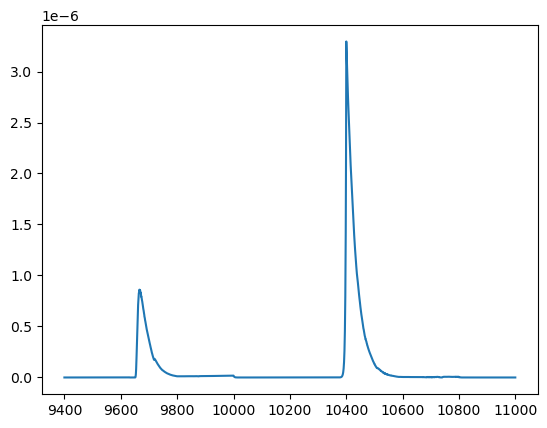

In [282]:
uu_ = np.array(uu_)
plt.plot(w_cut, uu_[:, -1, 0, 0])

In [283]:
def plot_for_selected_height(uu_, w_cut, selected_height_index, angle_values, height_values):
    plt.figure()
    
    # Строим линии для каждого угла при выбранной высоте
    num_angles = uu_.shape[1]
    for angle_idx in range(12, num_angles, 3):
        # Выбираем срез по выбранной высоте
        intensities = uu_[:, angle_idx, selected_height_index, 0]
        # Добавляем линию с подписью (явным значением угла)
        label = r'$\cos \theta$' + f': {angle_values[angle_idx]}'
        plt.plot(w_cut, intensities, label=label)
    
    plt.xlabel('w, $cm^{-1}$')
    plt.ylabel('Intensity')
    # Выводим реальное значение выбранной высоты
    selected_height_value = height_values[selected_height_index]
    # plt.title(f'Intensity at {int(selected_height_value)} km')
    plt.title(f'Intensity at the top boundary')
    plt.legend()  # Включаем легенду
    plt.grid(True)
    plt.show()


def plot_for_selected_angle(uu_, w_cut, selected_angle_index, angle_values, height_values):
    plt.figure()
    
    # Строим линии для каждой третьей высоты при выбранном угле
    num_heights = uu_.shape[2]
    for height_idx in range(0, num_heights, 30):  # Шаг 3 для высоты
        # Выбираем срез по выбранному углу
        intensities = uu_[:, selected_angle_index, height_idx, 0]
        # Добавляем линию с подписью (явным значением высоты)
        plt.plot(w_cut, intensities, label=f'Height: {height_values[height_idx]}')
    
    plt.xlabel('w_cut')
    plt.ylabel('Intensity')
    # Выводим реальное значение выбранного угла
    selected_angle_value = angle_values[selected_angle_index]
    plt.title(f'Lines for Angle: {selected_angle_value}')
    plt.legend()  # Включаем легенду
    plt.grid(True)
    plt.show()

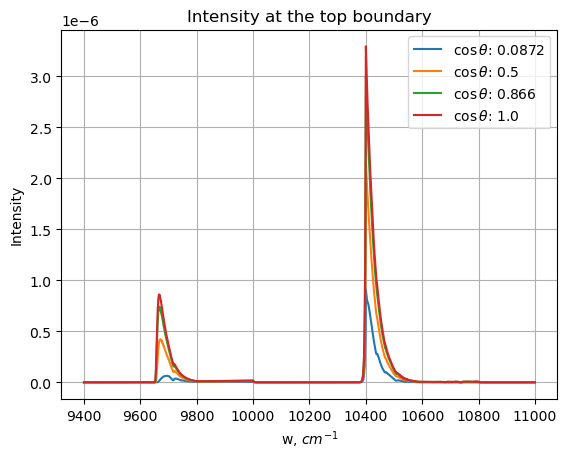

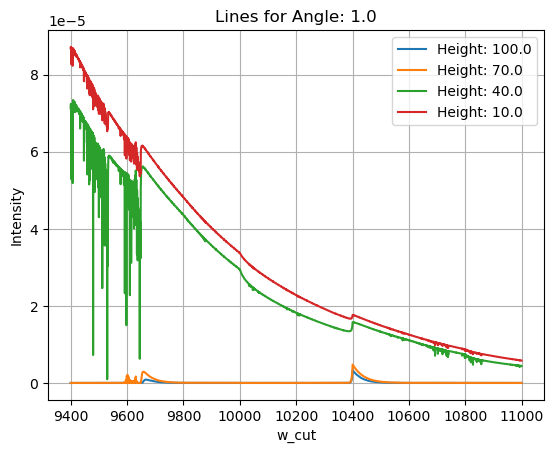

In [284]:
selected_thickness_index = 0  # индекс для высоты
selected_angle_index = -1  # индекс для угла

# Строим первый график
plot_for_selected_height(uu_, w_cut, selected_thickness_index, UMU, ZZ)

# Строим второй график
plot_for_selected_angle(uu_, w_cut, selected_angle_index, UMU, ZZ)

In [285]:
uu_.shape

(3200, 22, 101, 1)

In [286]:
w_cut

array([ 9400. ,  9400.5,  9401. , ..., 10998.5, 10999. , 10999.5])

In [287]:
uu.shape

(22, 101, 1)

In [288]:
uu[10, 0, 0]

0.0

In [289]:
TAUSUM[:,0]

array([9.05544468e-01, 8.64790916e-01, 8.25157990e-01, 7.86843451e-01,
       7.49848043e-01, 7.14204296e-01, 6.80176577e-01, 6.47742723e-01,
       6.17329215e-01, 5.89255162e-01, 5.63573170e-01, 5.40898145e-01,
       5.21891341e-01, 5.07202753e-01, 4.97694791e-01, 4.94935938e-01,
       5.00877931e-01, 5.17845561e-01, 5.48900183e-01, 5.98331776e-01,
       6.71937559e-01, 7.77034869e-01, 9.23671072e-01, 1.12555932e+00,
       1.40045327e+00, 1.77213907e+00, 2.27237416e+00, 2.94337915e+00,
       3.84124751e+00, 5.04086373e+00, 6.64199400e+00, 8.77716699e+00,
       1.16235114e+01, 1.54179055e+01, 2.02667112e+01, 2.27924654e+01,
       2.25873655e+01, 2.26678668e+01, 2.33469045e+01, 2.55258427e+01,
       2.71240454e+01, 2.70777894e+01, 2.70809818e+01, 2.70824040e+01,
       2.70548075e+01, 2.70336602e+01, 2.70173517e+01, 2.70046563e+01,
       2.69946761e+01, 2.69868195e+01, 2.69805519e+01, 1.74659267e+01,
       5.44347853e+00, 2.01013851e+00, 7.47566968e-01, 2.82228170e-01,
      

In [290]:
SSALB[:,0].shape

(100,)

In [291]:
min(GF), max(GF)

(1.598290319800026e-10, 0.8036995749971667)

In [292]:
GF

array([[7.55287553e-01, 7.55282563e-01, 7.55277551e-01, ...,
        7.59181690e-01, 7.59159298e-01, 7.59136995e-01],
       [7.55288732e-01, 7.55283745e-01, 7.55278736e-01, ...,
        7.59183907e-01, 7.59161512e-01, 7.59139204e-01],
       [7.55289778e-01, 7.55284793e-01, 7.55279787e-01, ...,
        7.59185873e-01, 7.59163474e-01, 7.59141163e-01],
       ...,
       [1.48670095e-08, 1.48851834e-08, 1.49033490e-08, ...,
        7.78497269e-09, 7.80233482e-09, 7.81969038e-09],
       [1.00815842e-08, 1.00939083e-08, 1.01062267e-08, ...,
        5.27913311e-09, 5.29090669e-09, 5.30267581e-09],
       [6.83796724e-09, 6.84632621e-09, 6.85468134e-09, ...,
        3.58064462e-09, 3.58863021e-09, 3.59661278e-09]])

In [293]:
np.any()

TypeError: any() missing 1 required positional argument: 'a'

In [ ]:
TAUCL[:,0]

In [ ]:
TT.shape

In [ ]:
ZZ.shape[0]

In [ ]:
gas_abs.shape

In [ ]:
rayleigh.shape

In [ ]:
aer_ext_interp.shape

In [ ]:
SCACL.shape

In [ ]:
LEGW.shape